# Assignment 6: Neural Networks


## 1. Backpropagation - Essentials

As you examined in class, a simple layer in a feedforward neural network can be expressed as the following:

$$h = Wx + b$$

$$t = \sigma(h)$$

$$\mathcal{L} = \frac{1}{2}(y - t)^2$$

where $x$ is the input, $W$ is the weight matrix at this node, $b$ is the bias added at the node, $\sigma(\cdot)$ is the activation function, $y$ is the label, and $\mathcal{L}$ is the loss.

The activation function and the loss function (squared loss used here) are choices made when creating a neural network. 


### a. What are the unknowns in the problem?

Answer: W and b


### b. What do we want minimize?

Answer: Loss function

### c. What method could we use to find the unknowns?

Answer: Gradient Descent

### d. Find the partial derivatives of L with respect to the unknowns. 

Assume we use ReLU for the activation function.

Answer:


$$ \frac{\partial\mathcal{L}}{\partial W} = \frac{\partial\mathcal{L}}{\partial t} \cdot \frac{\partial\mathcal{t}}{\partial h} \cdot \frac{\partial h}{\partial W}$$

$$ \frac{\partial\mathcal{L}}{\partial b} = \frac{\partial\mathcal{L}}{\partial t} \cdot \frac{\partial\mathcal{t}}{\partial h} \cdot \frac{\partial h}{\partial b}$$

where

$$ \frac{\partial\mathcal{L}}{\partial t} = -(y-t)$$

$$
     \frac{\partial\mathcal{t}}{\partial h} = \sigma^{\prime}(h) = \left\{
                \begin{array}{ll}
                  1 \;\;\; ; \;\;\; h > 0 \\
                  0 \;\;\; ; \;\;\; h \leq 0\\
                \end{array}
              \right.
$$

$$ \frac{\partial h}{\partial W} = x$$

$$ \frac{\partial h}{\partial b} = 1$$

## 2. Backpropogation

A neural network is regarded as compositional, in that the output of one layer feeds in as the input to the next layer. Using the the same notation as above but ignoring the bias $b$ for simplicity:

$$t = \sigma_L(W_L \sigma_{L-1}(...\sigma_2(W_2 \sigma_1(W_1x))...))$$

Here $x$ is the original input data, and $t$ is the output of the neural network.

Even more simply, we can look at each layer L:

$$N_1\rightarrow N_2\rightarrow N_3\rightarrow ... N_{L-1}\rightarrow N_L $$

The idea here is the same - we will need to solve for partial derivatives for each layer to set the unknowns. As the previous layer feeds into the next, you can only solve for a Jacobian (vector of partials) one wrt one layer down e.g. we can first solve for

$$ J_{N_L} (N_{L-1})$$

the Jacobian of $N_L$ with respect to $N_{L-1}$

### a. For the above simple representation, write out the Jacobian of the the final layer with respect to the first layer.

Answer: Chain Rule

$$ J_{N_L} (N_{1}) = J_{N_L} (N_{L-1}) * J_{N_{L-1}} (N_{L-2}) * \cdot\cdot\cdot * J_{N_{3}} (N_{2}) * J_{N_{2}} (N_{1}) $$


### b. Based on the equation you've described above, explain using time or space complexity why the best way to solve for the gradient in 2a. is to work backwards.

Answer:

The Jacobian of the last layer, $N_L$,  with respect to the second last,  $N_{L-1}$, results in a vector as the loss is a scalar. Comparatively, the following Jacobians are matrices (multiple variables in each layer, need to find gradients of all variables in layer $i$ w.r.t. *each* variable in layer $i-1$). 

So by going backwards, we're only finding matrix-vector products. Compare this to matrix-matrix products going forward, which is slower and less memory efficient. 

Matrix-vector has better time complexity than matrix-matrix; $O(n^2)$ vs $O(n^3)$ (referring to naive implementations, many algorithms exist for optimizing this + parallelization, but matrix-vector still inherently faster).

Matrix-vector has better space complexity than matrix-matrix; for each matrix-matrix multiplication, you need to put in memory the entire output matrix in memory. Going backwrds, output for each matrix-vector will be a vector. 


## 3. Simple Neural Network

Here you'll try out writing a neural network for a simple classification problem. For full credit, the final test accuracy should be above 0.6.

The dataset is of cell images from thin blood smear slides of segmented cells, with labels indicating the presence of malaria.

Source: https://lhncbc.nlm.nih.gov/publication/pub9932

Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6544011/

Some setup to start with:

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [0]:
malaria, info = tfds.load(name="malaria", split="train", with_info=True)
malaria = malaria.shuffle(30000).prefetch(tf.data.experimental.AUTOTUNE)
info

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incomplete7ZTVKJ/malaria-train.tfrecord



Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
      and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger, 
      Stefan and Thoma, George R}

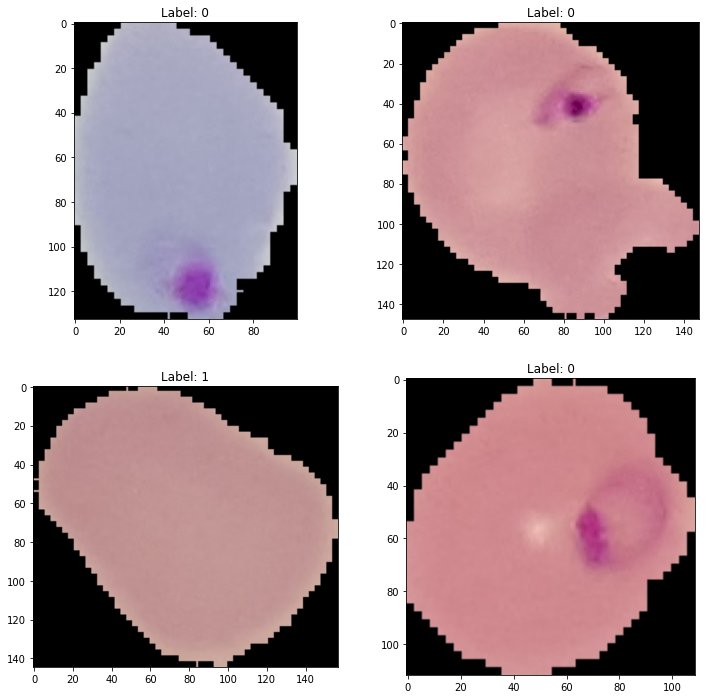

In [0]:
# Visualize some images
plt.figure(figsize=(12,12))

for i, feature in enumerate(malaria.take(4)):
    image = feature["image"].numpy()
    label = feature["label"].numpy()
    
    plt.subplot(2, 2, i+1)
    plt.title("Label: "+str(label))
    plt.imshow(image)
    # i+=1
plt.show()

### a. Extract some samples from the malaria dataset

Hints:

* Keep the total number of samples small ( < 10000) - it largely depends on your memory (if your notebook starts to crash, reduce the number of samples and try again)
* The dimension of each image is height * width * 3, with the 3 representing the number of channels 
* The height and width of the images aren't all the same, so resize all of them to be 133 by 133 (see [tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize))
* The possibles labels are 0s and 1s (scalars)
* Split into a training and testing set (a split like 80:20 train to test is reasonable)


In [0]:
# TODO: Initialize to the correct shapes with zeros
train_images = np.zeros((4000, 133, 133, 3))
train_labels = np.zeros(4000)
test_images = np.zeros((1000, 133, 133, 3))
test_labels = np.zeros(1000)

# TODO: Fill in the splits above
for i, feature in enumerate(malaria.take(5000)):

    image = cv2.resize(feature["image"].numpy(), (133, 133))
    label = feature["label"]

    if i >= 4000:
        test_images[i-4000] = image
        test_labels[i-4000] = label.numpy()
    else:
        train_images[i] = image
        train_labels[i] = label.numpy()

In [0]:
train_images[0].shape

(133, 133, 3)

### b. Add some layers to the model

Hints:

*   See examples of layers in the Keras documentation: https://keras.io/layers/core/
*   For the first layer, provide an input_shape, which refers to the shape of an image from your dataset

See examples at https://www.tensorflow.org/tutorials



In [0]:
model = tf.keras.Sequential()
# TODO:
model.add(tf.keras.layers.InputLayer(input_shape=(133,133,3)))

for i in range(2):
    model.add(tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), activation="relu"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=2))

model.add(tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), activation="relu"))
model.add(tf.keras.layers.Flatten())

for i in range(5):
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

### c. Choose how to train the above model

Pick an optimizer, loss function, and metric. If you choose something not covered in class, give a brief explanation and an advantage of your choice.

*   Optimizers: https://keras.io/optimizers/
*   Losses: https://keras.io/losses/
*   Metrics: https://keras.io/metrics/

### Reasoning:

TODO:


In [0]:
# TODO:
opt = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.MeanSquaredError()
metric = ["accuracy"] # Just a string of the chosen metric

In [0]:
model.compile(optimizer=opt,
              loss=loss_func,
              metrics=metric)

### d. Train the model

Choose an appropriate number of epochs (Hint: try some different values)

In [0]:
# TODO:
num_epochs = 10

model.fit(train_images, train_labels, epochs=num_epochs)

Epoch 1/10
125/125 [==============================] - 1s 10ms/step - loss: 1.1516 - accuracy: 0.5443
Epoch 2/10
125/125 [==============================] - 1s 10ms/step - loss: 0.2378 - accuracy: 0.6055
Epoch 3/10
125/125 [==============================] - 1s 10ms/step - loss: 0.2293 - accuracy: 0.6275
Epoch 4/10
125/125 [==============================] - 1s 10ms/step - loss: 0.2153 - accuracy: 0.6580
Epoch 5/10
125/125 [==============================] - 1s 10ms/step - loss: 0.1998 - accuracy: 0.6945
Epoch 6/10
125/125 [==============================] - 1s 10ms/step - loss: 0.1542 - accuracy: 0.7935
Epoch 7/10
125/125 [==============================] - 1s 10ms/step - loss: 0.1180 - accuracy: 0.8505
Epoch 8/10
125/125 [==============================] - 1s 10ms/step - loss: 0.0944 - accuracy: 0.8907
Epoch 9/10
125/125 [==============================] - 1s 10ms/step - loss: 0.0688 - accuracy: 0.9220
Epoch 10/10
125/125 [==============================] - 1s 10ms/step - loss: 0.0546 - accura

### e. Evaluate based on the testing set

Must be greater that 0.55 for full credit

In [0]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

32/32 - 0s - loss: 0.0597 - accuracy: 0.9240

Test accuracy: 0.9240000247955322


### f. Based on the above accuracies between the testing and training sets, did you overfit while training?

Answers vary, but any test loss significantly lower than the final training loss implies overfitting (the one above seems fine) 


### g. (Extra Credit) Improve your model to achieve an accuracy of greater than 0.70 on the testing set.